# Data Processing and Model Training - Titanic Dataset

In this notebook we define a proof of concept data processing including both the preprocessing and preparation of the data and the classification model as well. Bundling these two components together allows us to to tune both at the same time to find best fit during the training, and later deploy them as a unit.

### Package imports

The warnings library is used to supress sklearn warning and keep the cell outputs clean. For example some parameters during the hyperparameter training might not be compatible. In these cases sklearn puts out a warning, to tell the user of this issue, but since this doesn't affect the rest of the parameter combinations, and the hyperparameter tuning concludes successfully.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## Configurations

**features_to_use**: This list contains the whitelist of column names which contain relevant information for the training.

**numeric_features**, **categorical_features**: These lists contain the columns names of numeric and categorical features, and are used to separate them so that we can apply different transformation steps to them.

**param_grid**: Grid search parameters for the hyperparameter tuning.

In [2]:
# Data
features_to_use = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# Hyperparemeter tuning
param_grid = {
    'data_pipe__preprocessor__num__imputer__strategy': ['mean', 'median', 'most_frequent', 'constant'],
    'data_pipe__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler()],
    'data_pipe__preprocessor__cat__imputer__strategy': ['mean', 'median', 'most_frequent', 'constant'],
    'data_pipe__feature_selector__k': list(range(1, 8)),
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
}

## Data processing pipeline definition

Here we define the data processing pipeline. The parameters of each component, such as the strategy of the SimpleImputer, are just default values for testing purposes. The hyperparameter tuning is going to overwrite them.

The categorical and numerical features are handled separately. First we impute the missing values in them, then categorical values are encoded, while numerical values are scaled.
After the transformation steps above, we apply a feature selection layer, and then we connect it's output to the classifier.

In [3]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
feature_selector = SelectKBest(k='all')

data_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
])

pipeline = Pipeline(steps=[
    ('data_pipe', data_pipe),
    ('classifier', LogisticRegression(C=1, solver="lbfgs", max_iter=1000))
])

## Data import

In [4]:
df_train = pd.read_csv('../data/titanic.csv', index_col='PassengerId')
df_train = df_train[features_to_use]
x_train = df_train.drop(columns='Survived')
y_train = df_train['Survived']

## Training

For the training we are using grid search hyperparameter tuning with stratified K-fold crossvalidation.

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring="accuracy", cv=skf, verbose=1)

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 2688 candidates, totalling 13440 fits


,estimator,Pipeline(step..._iter=1000))])
,param_grid,"{'classifier__C': [0.1, 1, ...], 'classifier__solver': ['lbfgs', 'liblinear', ...], 'data_pipe__feature_selector__k': [1, 2, ...], 'data_pipe__preprocessor__cat__imputer__strategy': ['mean', 'median', ...], ...}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,steps,"[('preprocessor', ...), ('feature_selector', ...)]"


The best parameters and the accuracy score of the model:

In [6]:
print("Best Parameters found:\n")
for k, v in grid_search.best_params_.items():
    print(f"{k}: {v}")
print("")
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters found:

classifier__C: 0.1
classifier__solver: lbfgs
data_pipe__feature_selector__k: 1
data_pipe__preprocessor__cat__imputer__strategy: most_frequent
data_pipe__preprocessor__num__imputer__strategy: mean
data_pipe__preprocessor__num__scaler: MinMaxScaler()

Best Cross-Validation Score: 0.786761659657272


Now we restore the model with the best parameters

In [7]:
best_model = grid_search.best_estimator_

# Evaluation

You can see the best fitted model parameters above. This classifier reached a training accuracy of ~78.68%.

This model chose to only 'Sex_female' column, which is created from the 'Sex' column using one-hot encoding.

On the test set this lucky choice results in 100% accuracy, but only because in the training set all female passengers survive and all males die.

In [8]:
df_test = pd.read_csv('../data/titanic_test.csv', index_col='PassengerId')
df_test = df_test[features_to_use]
x_test = df_test.drop(columns='Survived')
y_test = df_test['Survived']

y_pred = best_model.predict(x_test)

print("Accuracy of the model on the test dataset:", accuracy_score(y_test, y_pred))

Accuracy of the model on the test dataset: 1.0


In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00       152

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418



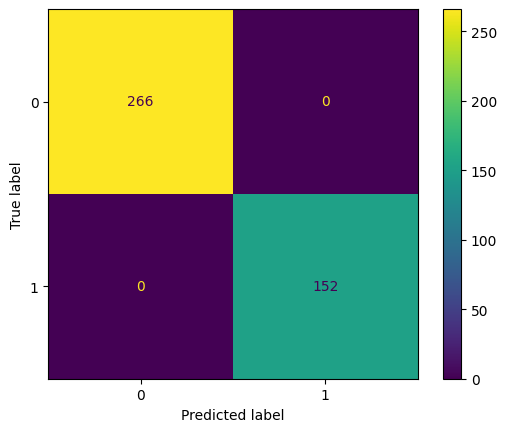

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

We can check which features were selected by the model

In [11]:
feature_selector = \
    best_model.named_steps['data_pipe'].named_steps['feature_selector']

categorical_transformer = \
    best_model\
    .named_steps['data_pipe']\
    .named_steps['preprocessor']\
    .named_transformers_['cat']\
    .named_steps['encoder']

feature_names = []
feature_names.extend(numeric_features)

encoded_cat_features = \
    categorical_transformer.get_feature_names_out(categorical_features)
feature_names.extend(encoded_cat_features)

selected_mask = feature_selector.get_support()
selected_features = np.array(feature_names)[selected_mask]

print("Selected features:", selected_features.tolist())

Selected features: ['Sex_female']
